<a href="https://www.kaggle.com/code/peremartramanonellas/house-prices-how-to-deal-with-the-data?scriptVersionId=124700547" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

As you know this is based in the competition **House Prices - Advanced Regression Techniques** 

What can be found in the notebook? 
- Identify columns with few values that we can drop. 
- How to treat the NULL values. 
- Study the data with BoxPlots, scatterplots, heatmaps... 
- Identify the most correlated features.
- Identify and correct the skew values. 
- Transform all the data to numeric. 
- Categorize the data. 
- Scale the numeric data, if necesary, with StandarScaler or MinMaxScaler. 
- Use a model, get predictions and submit results. 

I did my best to explain each step. If you have any comment or question, please don't hesitate to use the comments section. 

- <a href='#sectiondata'>Data</a>

  - <a href='#cleannulls'>Clean Nulls</a>

    - <a href='#heatmap'>HeatMap Garage</a>

  - <a href='#scaling'>Scaling</a>

  - <a href='#correlated'>Select correlated features</a>

- <a href='#training'>Create & Training the model</a>

  - <a href='#submission'>Submission</a>
 
- <a href='#inspirations'>Inspirations</a>



In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

In [2]:
#Import libraries 

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

%matplotlib inline   

In [3]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

#I'm going to join the train & Test Data in order to do the same transformations. 
df_housing=pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

#keeping the number of elements in the train dataframe. 
TRAIN_ELEMENTS_INDEX = df_train.index.max()

df_train.shape, df_test.shape, df_housing.shape


((1460, 81), (1459, 80), (2919, 81))

# Data.<a id='sectiondata'></a> 
Actions that we should do with the Data: 
- Identify columns with unique values.  
- Clean / Remove / Replace the Nulls. 
- Replace all the non numeric values
- Check for outliers
- Standarize / Normalize or adapt the numeric values.

 

In [4]:
#Just a quick look to our data. 
df_housing.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000.0
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000.0
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000.0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900.0
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000.0


As you can see, we have some columns with just a few values, let's check their *uniquevalues* and take a decisión if we want to keep, or not, the column. 

In [5]:
#check the number of elements in each unique value in the columns. c
COLS_TO_CHECK = ['Street', 'Utilities', 'Condition2', 
                'LandSlope', 'RoofMatl', 'ExterCond', 'Heating', 
                'CentralAir', 'GarageCond', 'Electrical']

#I create a DataFrame where store the Data
dftemp = pd.DataFrame(columns=['col_name', 'value', 'count'])

#In every colum to check I get the values and number of them, 
#and store in the DataFrame
for ctc in COLS_TO_CHECK: 
    dcol = df_housing[ctc].value_counts()
    for i in range(len(dcol)):
        row = {'col_name': ctc, 
              'value': dcol.index[i], 
              'count': dcol[i]}
        df_row = pd.DataFrame([row])
        dftemp = pd.concat([dftemp, df_row], axis=0, ignore_index=True)

In [6]:
#A list of all the values, it's easy to identify some that we can drop. 
dftemp

,col_name,value,count
0,Street,Pave,2907
1,Street,Grvl,12
2,Utilities,AllPub,2916
3,Utilities,NoSeWa,1
4,Condition2,Norm,2889
5,Condition2,Feedr,13
6,Condition2,Artery,5
7,Condition2,PosN,4
8,Condition2,PosA,4
9,Condition2,RRNn,2


It's clear to me that we can Drop *Street* and *Utilities* without any doubt. In *Utilities* we have just two values and one of them is present in only one row. 

In [7]:
df_housing.drop(['Street', 'Utilities'], axis=1, inplace=True)

## Clean the Nulls.<a id='cleannulls'></a> 

In [8]:
#change the ppandas visualization options to view all columns an rows if necessary. 
pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 1000); 
df_housing.shape

(2919, 79)

We have 2919 rows by 79 columns in the train Dataset . 

In [9]:
df_housing.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [10]:
#Get the numbers of Null values in columns, in descending order. 
df_housing.isna().sum().sort_values(ascending=False).head(40
                                                         )

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageCond        159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
BsmtFullBath        2
Functional          2
BsmtFinSF2          1
SaleType            1
BsmtUnfSF           1
Electrical          1
BsmtFinSF1          1
TotalBsmtSF         1
GarageCars          1
GarageArea          1
KitchenQual         1
Exterior2nd         1
Exterior1st         1
Fireplaces          0
SaleCondition       0
TotRmsAbvGrd        0
PavedDrive          0
YrSold              0
WoodDeckSF          0
dtype: int64

There are columns with a lot of empty rows. Usually **the best that we can do with the columns with a big number of empty data is delete it**, because we can't fill with invented values. 

To deal with empty data we have some different options how to deal with empty values: 

**Delete the column:** When the number of rows with empty values is really big, the best option is delete the entire column. I have no a magic number, but if it's more than 80% of rows with empty values I normally delete the column. 

**Replace the values:** Sometimes there are empty values because it indicates a category, and this category dosn't apply to some of the registers. 
That's the case of Fence in this dataset. There are a lot of properties without a Fence, but the properties with a Fence have different categories of Fences that affect to the price of this properties. In this case we can fill the empty row with the category *No. 

**Delete the rows**: When the empty is in a feature with a strong correlation with the label, the best solution is delete the rows. But in this case I'm going to avoid it, because I Joined the train and test dataset. To be able to delete rowns I should have joined them with a different technique. 

**By the moment, we are going to delete the columns:PoolQC. MiscFeature,  Alley and Id.**


In [11]:
df_house_clean = df_housing.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley'], axis=1)

<AxesSubplot:title={'center':'Fence '}, xlabel='Fence', ylabel='SalePrice'>

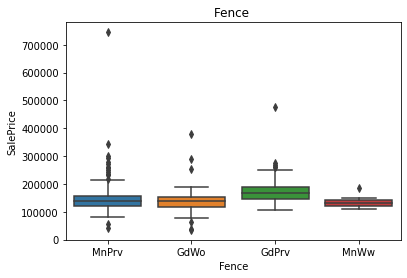

In [12]:
plt.title('Fence ')
#Note that I'm getting only the Train part of the Dataframe, the test have no SalePrice
sns.boxplot(x='Fence', y='SalePrice', data=df_house_clean[:TRAIN_ELEMENTS_INDEX:])

I can't se a clear relathionship between Fence and the SalePrice, and there are a lot of outliers values. We can just delete this value too. 

In [13]:
df_house_clean.drop(['Fence'], axis=1, inplace=True)

In [14]:
#Check the unique values in FirePlaceQu
df_house_clean['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

I'm going to fill the Null Values with a "No", just to have more information in the subplot

<AxesSubplot:title={'center':'FireplaceQu '}, xlabel='FireplaceQu', ylabel='SalePrice'>

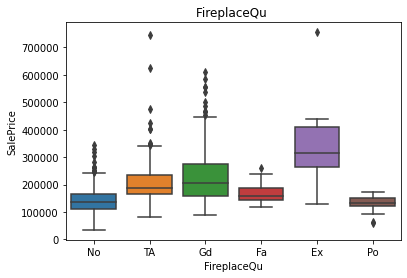

In [15]:
df_house_clean['FireplaceQu'] = df_house_clean['FireplaceQu'].fillna('No')
plt.title('FireplaceQu ')
sns.boxplot(x='FireplaceQu', y='SalePrice', data=df_house_clean[:TRAIN_ELEMENTS_INDEX:])

Ok, it seems that it can be a correlation between the type of fireplace and the *SalePrice*, but it's not strong enough and there are a lot of outliners. I'm not going to keep it. 

Time to check the values in *LotFrontage*. It contains the linear feet of street connected to property. As a resident in a City in Europe I have no Idea if this data can be important or not in the local Market of the Dataset. By the moment we can fill the values with the mean. 

In [16]:
df_house_clean['LotFrontage'].unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.,  26.,  25., 119.,  31.,  28., 117., 113., 125., 135., 136.,
        22., 123., 195., 155., 126., 200., 131., 133.])

<AxesSubplot:title={'center':'LotFrontage '}, xlabel='LotFrontage', ylabel='SalePrice'>

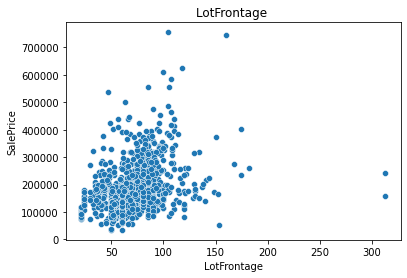

In [17]:
plt.title('LotFrontage ')
sns.scatterplot(x='LotFrontage', y='SalePrice', data=df_house_clean[:TRAIN_ELEMENTS_INDEX:])

I cant see a clear relation between the *LotFrontage* and the *SalePrice*, I'm  going to delete this value too. 


In [18]:
df_house_clean.drop(['LotFrontage'], axis=1, inplace=True)

Let's check again the columns with empty values
df_house_clean.isna().sum().sort_values(ascending=False).head(15)

In [19]:
df_house_clean.isna().sum().sort_values(ascending=False).head(15)

SalePrice       1459
GarageCond       159
GarageYrBlt      159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
dtype: int64

We still have a lot of columns with just a few Null values. But we need to decide what to do with them. It's important to know if the data is just numeric or it can be categorical. And when we know it, fill it, or maybe just remove the rows, or columns. 

We have 5 Garage variables with 81 registers with Nulls, but we have others columns related to the garage without missing data. To decide if we can Delete the columns, the rows or fill it. We can study the correlation of all the garage columns, and try to identify wich one is more important to our model. 

At this moment some of this columns are not numeric, and we can calculate the Correlation. We can wait until all our Data is numeric, but I prefer to identify now if we can delete some of this data. 


### Heatmap Garage variables<a id='heatmap'></a>

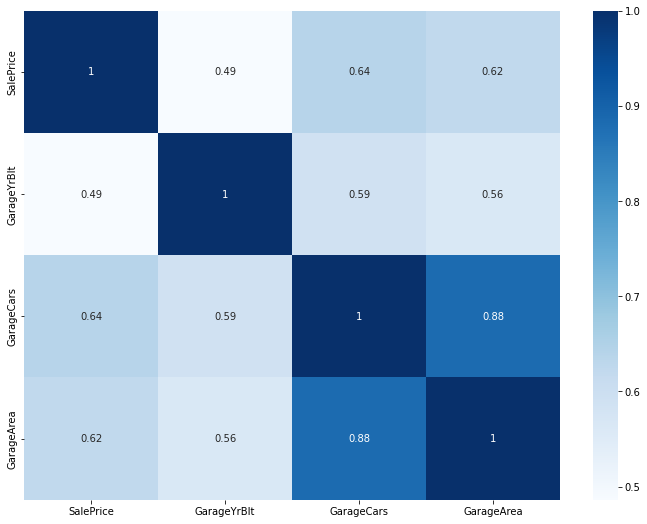

In [20]:
#saleprice correlation matrix with Garage Variables. 
cols = ['SalePrice','GarageType', 'GarageYrBlt', 'GarageCond', 
       'GarageFinish', 'GarageQual', 'GarageCars', 'GarageArea']

corrmat = df_house_clean[:TRAIN_ELEMENTS_INDEX:][cols].corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, cmap="Blues");

By the moment we can delete *GarageYrBlt*, and keep *GarageArea* and *GarageCars*, but for the name for sure that this Data is redundant. And if I have to choose one, I will choose *GarageArea*, but in the HeatMap we can see that *GarageCars* is more correlated, so....I'm going to Keep *GarageCars* (I believe in numbers). Maybe some garages have a large Area but it's not possible to fit more than one car. 

In [21]:
#Delete the columns
df_house_clean.drop(['GarageYrBlt', 'GarageArea'], axis=1, inplace=True)


#Fill the column
df_house_clean = df_house_clean.fillna(df_house_clean.mode().iloc[0])


Let's check if we have more Nulls: 

In [22]:
df_house_clean.isna().sum().sort_values(ascending=False).head(15)

MSSubClass      0
HalfBath        0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
FullBath        0
GarageType      0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
dtype: int64

Perfect, **we have no Nulls**. 

## Check the skew of the numeric values. 

In [23]:

#obtain all the numeric columns 
numeric_columns = list(df_house_clean.select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns)
numeric_columns




['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [24]:
skew_features = df_house_clean.select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).apply(lambda x: skew(x)).sort_values(ascending=False)


In [25]:
high_skew = skew_features[skew_features > 0.5]

#in skew_index we store the name of the columns
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))

#Store the skews colums in a DataFrame
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 26 numerical features with Skew > 0.5 :


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
dtype: float64

In [26]:
for col in skew_index: 
    if (col != 'SalePrice'):
        df_house_clean[col] = boxcox1p(df_house_clean[col], 
                                   boxcox_normmax(df_house_clean[col]+1))
    

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


## Transform Data to numeric. 
All the data must be numeric. And we have some columns that are in text. 

We have two ways to convert datas in numeric. 
- In the same column. We can assign a number to each category. But it have a problem. If we assign the numbers 1, 2 and 3 to three diferent categories. Our model will be confused because 2 is bigger than 1 and 3 bigger than 2, but it isn't important, we are just categorizing. I only recommend this kind of categorization in fields where bigger values have more impact in the label than the smaller ones. If we have a Column called GarageSize with the values small, medium, and big. We can convert this categories into 1, 2 and 3 (or a normalized value), because the size of the garage have a positive correlation with the prices of property. 

- In Categories. We create a new column for each value, and indicate if the row have this value with an 1 or a 0. This the most commom way to transform from text to numeric, but the text must be categorizable. Some times we need to create our own categories if we want to keep the data. As a sample, colors of a car, can be a lot of them, impossible to categorize, but we can distribute it in: Dark colors and clear colors, or maybe metallic colors. But it needs a lot of manual revisión.  


First we need to know with colums are not numeric. 

In [27]:
df_house_clean.loc[:, df_house_clean.dtypes == object]

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,No,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,No,Attchd,Unf,TA,TA,Y,WD,Normal
2915,RM,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,No,CarPort,Unf,TA,TA,Y,WD,Abnorml
2916,RL,Reg,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,WD,Abnorml
2917,RL,Reg,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,No,Attchd,Unf,TA,TA,Y,WD,Normal


In [28]:
object_columns = list(df_house_clean.select_dtypes(['object']).columns)
object_columns

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

We have 40 columns to transform, if we want to categorize all of them and we have 5 categories per column we will add 160 columns to the model.  

(40 * 5 = 200) - 40 = 160. 

It seems a lot, but it's not a problem. The problem is that not all of them are relevant, and we are fitting our model with a lot of useless informatión. But let's try it, we can delete it after all columns are converted when we can study the correlation of all columns. 

Just one sample with the column *LotShape*

In [29]:
df_housing['LotShape'].unique()

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

In [30]:
ls = pd.get_dummies(df_house_clean['LotShape'], prefix='LotShape')
ls

,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
0,0,0,0,1
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
2914,0,0,0,1
2915,0,0,0,1
2916,0,0,0,1
2917,0,0,0,1


As you can see, we have a new column for each categorie, and  every registry have a value of *1* in the category where it pertains. 

The next step is add this columns to our dataframe, and delete the original one, because we don't need it anymore. 

Now, we can do it for all the columns with data values in our Dataset, as we can see above in the list all of them are categorizables. 

In [31]:
df_house_clean.shape

(2919, 71)

In [32]:
#Copy the dataframe. 
df_house_cc = df_house_clean.copy(deep = True)

#Create the dummies for each column in the list of Obcjet columns
for obj_col in object_columns: 
    #print(obj_col)
    col_dum = pd.get_dummies(df_house_clean[obj_col], prefix=obj_col)
    df_house_cc = pd.concat ([df_house_cc,  col_dum], axis=1)
    
    #remove the original columns from the new dataframe
    df_house_cc.drop(obj_col, axis=1, inplace=True)

In [33]:
df_house_cc.shape

(2919, 270)

In [34]:
df_house_cc.isna().sum().sort_values(ascending=False).head(5)

MSSubClass          0
BsmtExposure_No     0
Foundation_Slab     0
Foundation_Stone    0
Foundation_Wood     0
dtype: int64

In [35]:
#Create a duplicate of the dataframe witout the Data Scaled. 
df_not_scaled = df_house_cc.copy(deep = True)

df_not_scaled.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N

## Scaling the numeric data <a id='scaling'></a>
We have our dataframe without nulls. But we need to do some more transformations in order to improve the data, and do it more usable. 

Now we are going to scalete, if necessary, the Data. 

We can do it in many ways, but we are using SciKitLearn, and we have two classes to do it: 

- **StandardScaler**: Will transform the numerical fields so that the mean of the field is 0 and the standard deviation is 1. 
- **MinMaxScaler**: scale the columns so that the minimum value of each column is 0 and the maximum value is 1. 

With this DataSet I think that StandardScaler is going to work better than MinMaxScaler, but feel free to check it by yourself. 

In [36]:
#We can add this line to the import Libraries section. 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

scaler = StandardScaler()

The easy way to scale: 

* scaler = StandardScaler() *

* df_to_scale_tmp = scaler.fit_transform(df_house_clean) *

* df_house_clean = pd.DataFrame(df_to_scale_tmp, columns=df_to_scale.columns) *

But in this way we scalate all the values un the dataset. I'm doing the same, but selecting first with columns I want to scale and copy it to a temporaru Dataset. We can select the columns manually, but I decided to Sacalate all the columsn with a std greater than 1. But this value is in a constant and I can do a lot of test changing this limit. 

The SalePrice deserves a special treatment. Is our label variable, and we must assure that it is following a normal distribution. 

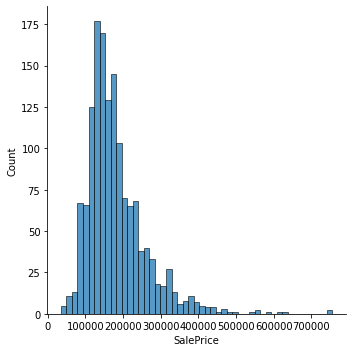

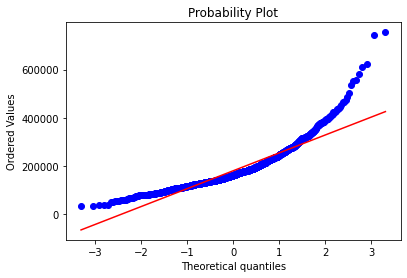

In [37]:
sns.displot(df_house_cc[:TRAIN_ELEMENTS_INDEX:]['SalePrice']);
fig = plt.figure()
res = stats.probplot(df_house_cc[:TRAIN_ELEMENTS_INDEX:]['SalePrice'], plot=plt)

In [38]:
#applying log transformation
df_house_cc['SalePrice'] = np.log(df_house_cc['SalePrice'])

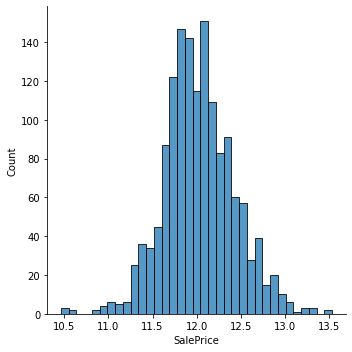

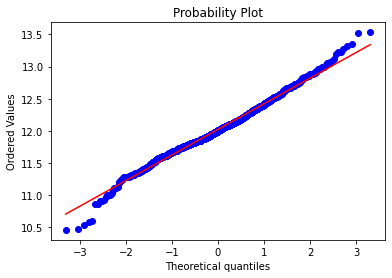

In [39]:
sns.displot(df_house_cc[:TRAIN_ELEMENTS_INDEX:]['SalePrice']);
fig = plt.figure()
res = stats.probplot(df_house_cc[:TRAIN_ELEMENTS_INDEX:]['SalePrice'], plot=plt)

Now that our Label is Normalized we can attack all the other columns. Sometimes is better to scale all of them, sometimes only some of them. Thas why I prepared this code where I can select the level of std desviation that I want to use as a limit to select the variables to Scale. 

And I can do experiments changing this value and check how it affetct to the final predictions. 

In [40]:
#We need to decide wich columns we want to scalate
#all of them with and std greater than 1 
LIMIT_TO_SCALE = 1
columns_to_scale = df_house_cc.columns.where(df_house_cc.std()  > 1)

df_to_scale = pd.DataFrame()

#We have all the columns in columns_to_scale
#we can copy each column in a new dataframe. 
for col_to_scale in columns_to_scale.dropna():
    df_to_scale[col_to_scale] = df_house_cc[col_to_scale]
    df_house_cc.drop(col_to_scale, axis=1, inplace=True)

In [41]:
df_house_cc.shape, df_to_scale.shape

((2919, 252), (2919, 18))

We have two dataframes: 
- df_to_scale: contains all the columns that we want to scale. 
- df_house_cc: is the original dataframe with the data Clean and Converted to numeric. We don't want to normalize all this dataframe because the categorical columns. 

Now it's time to normalize df_to_scale and replace the values in df_house_cc.

In [42]:
#Let's see the data in df_to_scale befote to scale. 
df_to_scale.head(5)

,MSSubClass,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,YrSold
0,6.502440,13.424520,7,2003,2003,19.378557,117.855863,0.0,30.016555,296.832338,1019.540733,0.000000,12.009558,0.000000,0.0,0.0,2,2008
1,4.250991,13.694527,6,1976,1976,0.000000,146.805798,0.0,44.178889,407.302427,0.000000,56.339208,0.000000,0.000000,0.0,0.0,5,2007
2,6.502440,14.034133,7,2001,2002,17.721069,91.575284,0.0,56.957796,314.805067,1034.306417,0.000000,9.849185,0.000000,0.0,0.0,9,2008
3,6.865584,13.683421,7,1915,1970,0.000000,52.776367,0.0,64.881737,268.234296,899.200533,0.000000,8.921746,16.012025,0.0,0.0,2,2006
4,6.502440,14.550142,8,2000,2000,25.323127,112.040325,0.0,61.233859,376.259375,1265.167706,42.351292,14.180238,0.000000,0.0,0.0,12,2008


Scalate the Data is really easy, now that we have the all the Data that we need to Scalate in a Dataframe, we only need 3 lines of code: 

In [43]:
#Create the Scaler
scaler = StandardScaler()

#Fit the Scaler with the data. 
df_to_scale_tmp = scaler.fit_transform(df_to_scale)

#Convert to dataframe the value returned by fit_transfom function. 
df_to_scale = pd.DataFrame(df_to_scale_tmp, columns=df_to_scale.columns)

In [44]:
#After scale. 
df_to_scale.head()

,MSSubClass,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,YrSold
0,0.349814,-0.125272,0.646183,1.046258,0.896833,1.032444,0.724690,-0.357352,-0.921053,-0.402368,1.202038,-0.85144,0.606786,-0.417108,-0.30343,-0.189069,-1.552184,0.157646
1,-1.079298,0.127070,-0.063185,0.154764,-0.395604,-0.733681,1.183898,-0.357352,-0.488310,0.507592,-0.780730,1.57340,-0.964794,-0.417108,-0.30343,-0.189069,-0.446925,-0.602962
2,0.349814,0.444457,0.646183,0.980221,0.848965,0.881384,0.307824,-0.357352,-0.097839,-0.254324,1.230754,-0.85144,0.324078,-0.417108,-0.30343,-0.189069,1.026753,0.157646
3,0.580320,0.116691,0.646183,-1.859351,-0.682812,-0.733681,-0.307610,-0.357352,0.144284,-0.637935,0.968004,-0.85144,0.202713,3.129000,-0.30343,-0.189069,-1.552184,-1.363569
4,0.349814,0.926706,1.355551,0.947203,0.753229,1.574221,0.632444,-0.357352,0.032820,0.251886,1.679725,0.97136,0.890842,-0.417108,-0.30343,-0.189069,2.132012,0.157646


In [45]:
#Replace the values not scaled by the scaled versión. 
for col_to_scale in columns_to_scale.dropna():
    df_house_cc[col_to_scale] = df_to_scale[col_to_scale]

In [46]:
df_house_cc.shape

(2919, 270)

In [47]:
#Lets see the data scaled jointly with all the other fields. 
df_house_cc.head(5)

,OverallCond,1stFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjL

## Select correlated features in a new dataset <a id='correlated'></a>
Nom that we have all the columns in numeric we can select the ones more correlated. But we are going to keep the dataset transformed but with all the columns to test it with the models. 

In [48]:
list_columns_ordered = df_house_cc.corr()['SalePrice'].sort_values(ascending=False).index
n=0

#I create a new DataFrame to contain only the columns that are correlated. 
df_correlated_columns = pd.DataFrame()

#Minimun correlation that we want. 
MIN_CORR = 0.4
for col in df_house_cc[:TRAIN_ELEMENTS_INDEX:].corr()['SalePrice'].sort_values(ascending=False):
    if (col > MIN_CORR or col < MIN_CORR * -1):
        print (list_columns_ordered[n])
        print (col)
        df_correlated_columns[list_columns_ordered[n]] = df_house_cc[list_columns_ordered[n]]
    
    n = n+1


SalePrice
1.0
OverallQual
0.817220700973612
GrLivArea
0.7302498257859353
GarageCars
0.6806768985069687
TotalBsmtSF
0.6153807828055382
1stFlrSF
0.608338889749126
FullBath
0.5947886534000912
YearBuilt
0.586554172575886
TotRmsAbvGrd
0.5656033406785919
YearRemodAdd
0.5400138225078915
Foundation_PConc
0.5308143681658325
ExterQual_Gd
0.5103364866029078
Fireplaces
0.49672899322758385
HeatingQC_Ex
0.46667231887823474
MasVnrArea
0.46395675039859374
BsmtQual_Ex
0.440704950701307
BsmtFinType1_GLQ
0.4383941459325458
LotArea
0.4270257618561195
OpenPorchSF
0.4197204603522652
KitchenQual_Gd
0.41390298501459977
GarageFinish_Fin
0.40653587220248893
KitchenQual_Ex
0.4003477931365159
FireplaceQu_No
-0.5100150339396856
BsmtQual_TA
-0.5382276876879853
KitchenQual_TA
-0.5383930701261412
GarageFinish_Unf
-0.5749439494912291
ExterQual_TA
-0.5965038565865083


In [49]:
df_correlated_columns.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,TotRmsAbvGrd,YearRemodAdd,Foundation_PConc,ExterQual_Gd,Fireplaces,HeatingQC_Ex,MasVnrArea,BsmtQual_Ex,BsmtFinType1_GLQ,LotArea,OpenPorchSF,KitchenQual_Gd,GarageFinish_Fin,KitchenQual_Ex,FireplaceQu_No,BsmtQual_TA,KitchenQual_TA,GarageFinish_Unf,ExterQual_TA
0,12.247694,0.646183,7.234115,2.0,-0.402368,5.318379,2,1.046258,2.238463,0.896833,1,1,0.000000,1,1.032444,0,1,-0.125272,0.606786,1,0,0,1,0,0,0,0
1,12.109011,-0.063185,6.947212,2.0,0.507592,5.550627,2,0.154764,1.978208,-0.395604,0,0,0.900816,1,-0.733681,0,0,0.127070,-0.964794,0,0,0,0,0,1,0,1
2,12.317167,0.646183,7.275132,2.0,-0.254324,5.362015,2,0.980221,1.978208,0.848965,1,1,0.900816,1,0.881384,0,1,0.444457,0.324078,1,0,0,0,0,0,0,0
3,11.849398,0.646183,7.237969,3.0,-0.637935,5.388291,1,-1.859351,2.116352,-0.682812,0,0,0.900816,0,-0.733681,0,0,0.116691,0.202713,1,0,0,0,1,0,1,1
4,12.429216,1.355551,7.470741,3.0,0.251886,5.493032,2,0.947203,2.347900,0.753229,1,1,0.900816,1,1.574221,0,1,0.926706,0.890842,1,0,0,0,0,0,0,0


Ok! **OUR DATA IS READY!** Let's use it! 

I have 3 different dataframes to test: 
- **df_correlated_columns**: A dataframe with all the modifications, and only with the columns witha correlation > 5. 

- **df_house_cc**: Without nulls and with all data in numeric and standarized, but with all the columns, not only the more correlated. 

- **df_not_scaled**: Without nuls and with all data in numeric but not standarized. 

And their respective test datasets. 


Just, one last step: Split the data. 

In [50]:
from sklearn.model_selection import train_test_split

#Split the data only correlated columns. 
y = df_correlated_columns[:TRAIN_ELEMENTS_INDEX:]['SalePrice']
X = df_correlated_columns[:TRAIN_ELEMENTS_INDEX:].drop(['SalePrice'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_correlated_columns.loc[TRAIN_ELEMENTS_INDEX + 1:, :].reset_index(drop=True).copy()
X_test.drop('SalePrice', axis=1, inplace=True)

#Split data with all transformations and all columns. 
y_cc = df_house_cc[:TRAIN_ELEMENTS_INDEX:]['SalePrice']
X_cc = df_house_cc[:TRAIN_ELEMENTS_INDEX:].drop(['SalePrice'], axis=1)
X_cc_train, X_cc_val, y_cc_train, y_cc_val = train_test_split(X_cc, y_cc, test_size=0.2, random_state=42)
X_cc_test = df_house_cc.loc[TRAIN_ELEMENTS_INDEX + 1:, :].reset_index(drop=True).copy()
X_cc_test.drop('SalePrice', axis=1, inplace=True)


In [51]:
X_cc_test.shape

(1459, 269)

# The Model & Test different DataFrames. <a id='training'></a>
I'm going to keep this part simple. It's a lot that you can do if you want to copy this notebook and improve the results obtained. You can test new models, I only test the ridge. Tune the hyperparameters, or maybe try blended models. 

In [52]:
def evaluate_regression(y_true, y_preds):
    from sklearn.metrics import r2_score
    """
    Evaluar modelo de regresion
    """
    r2_score = r2_score(y_true, y_preds)
    rmse=np.sqrt(mean_squared_error(y_true,y_preds))
    mae=mean_absolute_error(y_true, y_preds)

    print(f"KPIs-------------------------------------")
    print(f"r2: {r2_score * 100:.2f}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"KPIs-------------------------------------")
    return 

In [53]:
from sklearn import linear_model
#from sklearn import 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler



In [54]:
def train_eval_ridge(X_train, y_train, X_val, y_val):  
    model = linear_model.Ridge()
    model.fit(X_train, y_train)
    print(model.score(X_val, y_val))
    y_preds = model.predict(X_val)
    evaluate_regression(y_val, y_preds)
    return model 

In [55]:
model1 = train_eval_ridge(X_train, y_train, X_val, y_val)

0.8774636077607247
KPIs-------------------------------------
r2: 87.75
RMSE: 0.14317992776732655
MAE: 0.10007283040803427
KPIs-------------------------------------


In [56]:
model2 = train_eval_ridge(X_cc_train, y_cc_train, X_cc_val, y_cc_val)

0.9170118493863655
KPIs-------------------------------------
r2: 91.70
RMSE: 0.11783047745120477
MAE: 0.08232651990609444
KPIs-------------------------------------


In [57]:
#test_features = df_test_cc[:]
#print (test_features)
results1 = model1.predict(X_test)
results2 = model2.predict(X_cc_test)

## Submission <a id='submission'></a>

In [58]:
submission = pd.DataFrame()

submission['Id'] = df_test['Id']
submission['SalePrice'] = np.exp(results2)


submission.to_csv('./submission.csv', index=False, header=True)

In [59]:
submission

,Id,SalePrice
0,1461,116983.421767
1,1462,156369.571296
2,1463,181913.199130
3,1464,193564.300619
4,1465,198325.400385
...,...,...
1454,2915,86731.746993
1455,2916,83108.707425
1456,2917,167457.607608
1457,2918,124019.374801


# Inspirations: <a id='inspirations'></a>

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/code/apapiu/regularized-linear-models/notebook
https://www.kaggle.com/code/modassirafzal/housing-top-3
https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook


# # Feel free to copy and fork this notebook. 
I'm sure that you can improve easily the result of this notebook just working with the Model, or maybe changing the number of colums to scalate, the limit for the skew, or the limit to obtain the correlated columns. Or maybe using Mutual Information instead of correlation. 

Create new features, and delete some of the used... you can test a lot of ideas for your own! 
***
Just, if you like it, **please consider to upvote**! 
Please, if you improve the results of the predictions using any technique described, consider to share your notebook in the comments i will be delighted to explore and discuss your solution, and of course upvote it! 
***

Thanks! 

May the Data be with you ;-) 